In [1]:
# Notebook 03B : Prédiction Hybride avec Switching Brut / Lissé selon delta vs seuil

## 📥 1. Imports & Chargement des données enrichies

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

file_path = 'C:/Users/axxiv/Desktop/mm-5G.csv'
df = pd.read_csv(file_path)

df['debit_brut'] = df['Throughput']
df['debit_lisse'] = df['Throughput'].ewm(span=8, adjust=False).mean()
df['delta'] = df['debit_brut'] - df['debit_lisse']
df['variation_relative'] = df['delta'] / (df['debit_lisse'] + 1e-6)
df['seuil'] = df['delta'].rolling(window=15).std() * 1.5
df = df.fillna(0)


## 📏 2. Normalisation & séquences temporelles (brut & lissé)

In [3]:
features = ['debit_brut', 'debit_lisse', 'delta', 'variation_relative']
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df[features])

SEQ_LEN = 30

def create_sequences(data, target_index):
    X, y = [], []
    for i in range(SEQ_LEN, len(data)):
        X.append(data[i-SEQ_LEN:i])
        y.append(data[i, target_index])
    return np.array(X), np.array(y)

X_brut, y_brut = create_sequences(data_scaled, target_index=0)
X_lisse, y_lisse = create_sequences(data_scaled, target_index=1)
deltas = data_scaled[SEQ_LEN:, 2]
seuils = df['seuil'].values[SEQ_LEN:]


## 🔀 3. Split des données d'entraînement et de test

In [4]:
split = int(0.8 * len(X_brut))
Xb_train, Xb_test = X_brut[:split], X_brut[split:]
Yb_train, Yb_test = y_brut[:split], y_brut[split:]
Xl_train, Xl_test = X_lisse[:split], X_lisse[split:]
Yl_train, Yl_test = y_lisse[:split], y_lisse[split:]
deltas_test, seuils_test = deltas[split:], seuils[split:]


## 🧠 4. Modèle LSTM de base

In [5]:
def build_lstm():
    model = Sequential()
    model.add(LSTM(64, input_shape=(SEQ_LEN, X_brut.shape[2]), return_sequences=False))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model


## 🏋️ 5. Entraînement des modèles (25 epochs)

In [6]:
model_brut = build_lstm()
model_lisse = build_lstm()
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model_brut.fit(Xb_train, Yb_train, epochs=25, batch_size=32, validation_split=0.2, callbacks=[es], verbose=1)
model_lisse.fit(Xl_train, Yl_train, epochs=25, batch_size=32, validation_split=0.2, callbacks=[es], verbose=1)


C:\Users\axxiv\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/25
1362/1362 ━━━━━━━━━━━━━━━━━━━━ 39s 25ms/step - loss: 0.0163 - val_loss: 0.0087
Epoch 2/25
1362/1362 ━━━━━━━━━━━━━━━━━━━━ 35s 26ms/step - loss: 0.0089 - val_loss: 0.0089
Epoch 3/25
1362/1362 ━━━━━━━━━━━━━━━━━━━━ 41s 30ms/step - loss: 0.0090 - val_loss: 0.0086
Epoch 4/25
1362/1362 ━━━━━━━━━━━━━━━━━━━━ 37s 27ms/step - loss: 0.0089 - val_loss: 0.0086
Epoch 5/25
1362/1362 ━━━━━━━━━━━━━━━━━━━━ 97s 71ms/step - loss: 0.0086 - val_loss: 0.0087
Epoch 6/25
1362/1362 ━━━━━━━━━━━━━━━━━━━━ 49s 36ms/step - loss: 0.0090 - val_loss: 0.0085
Epoch 7/25
1362/1362 ━━━━━━━━━━━━━━━━━━━━ 42s 31ms/step - loss: 0.0086 - val_loss: 0.0085
Epoch 8/25
1362/1362 ━━━━━━━━━━━━━━━━━━━━ 41s 30ms/step - loss: 0.0088 - val_loss: 0.0086
Epoch 9/25
1362/1362 ━━━━━━━━━━━━━━━━━━━━ 44s 32ms/step - loss: 0.0088 - val_loss: 0.0085
Epoch 10/25
1362/1362 ━━━━━━━━━━━━━━━━━━━━ 45s 33ms/step - loss: 0.0086 - val_loss: 0.0086
Epoch 11/25
1362/1362 ━━━━━━━━━━━━━━━━━━━━ 170s 125ms/step - loss: 0.0087 - val_loss: 0.0088
Epoch 

## 🔀 6. Switching prédictif selon delta vs seuil

In [7]:
pred_brut = model_brut.predict(Xb_test)
pred_lisse = model_lisse.predict(Xl_test)

pred_final = []
for i in range(len(deltas_test)):
    if abs(deltas_test[i]) > seuils_test[i]:
        pred_final.append(pred_brut[i][0])
    else:
        pred_final.append(pred_lisse[i][0])
pred_final = np.array(pred_final)


426/426 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step
426/426 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step


## 📈 7. Évaluation et Visualisation (Prédiction vs Réel)

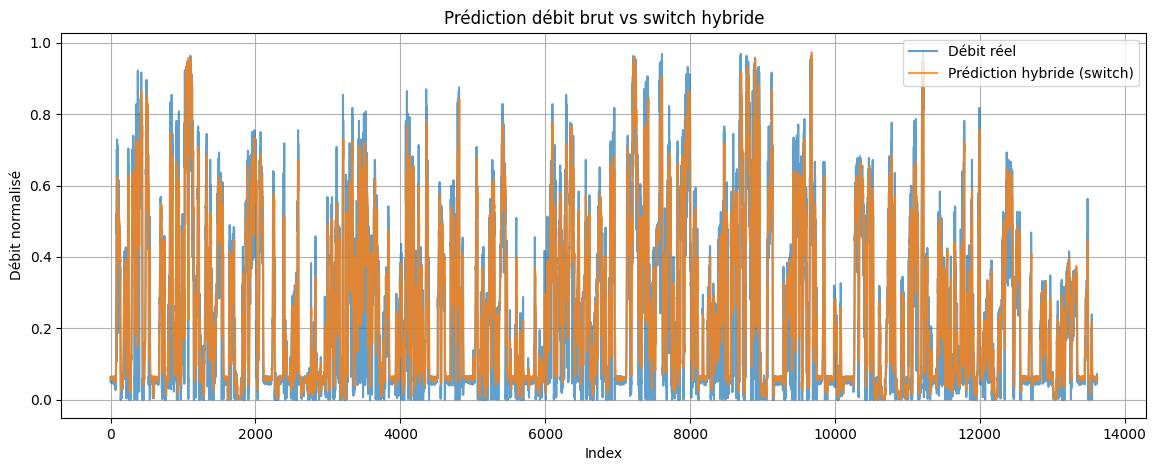

MSE : 0.0116
MAE : 0.0672
R² : 0.7923


In [8]:
plt.figure(figsize=(14,5))
plt.plot(Yb_test, label='Débit réel', alpha=0.7)
plt.plot(pred_final, label='Prédiction hybride (switch)', alpha=0.8)
plt.title("Prédiction débit brut vs switch hybride")
plt.xlabel("Index")
plt.ylabel("Débit normalisé")
plt.legend()
plt.grid(True)
plt.show()

mse = mean_squared_error(Yb_test, pred_final)
mae = mean_absolute_error(Yb_test, pred_final)
r2 = r2_score(Yb_test, pred_final)

print(f"MSE : {mse:.4f}")
print(f"MAE : {mae:.4f}")
print(f"R² : {r2:.4f}")
